In [150]:
#Enabling gpu for better  speed performance
!nvidia-smi
import torch
print("torch.cuda:", torch.cuda.is_available(), torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)


Thu Sep 11 03:45:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P0             28W /   70W |    9850MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# **Dataset Description**

**Dataset**: Brain Tumor MRI Dataset by Masoud Nickparvar (Kaggle)

- **Total images**: ~7,023 grayscale MRI slices in JPEG format.
- **Classes**: Four categories — `glioma`, `meningioma`, `pituitary`, and `no tumor` (healthy brain).
- Sample distribution (from one study):
  - **Training set**: Glioma (1,321), Meningioma (1,339), No Tumor (1,595), Pituitary (1,457)
  - **Testing set**: Glioma (300), Meningioma (306), No Tumor (405), Pituitary (300)  
  Total: ~7,023 images :contentReference[oaicite:6]{index=6}.

**Use cases in literature**:
- **InceptionV3** achieved ~97.12% average accuracy for this dataset :contentReference[oaicite:7]{index=7}.
- **EfficientNet-B0** reported ~99.54% accuracy in comparative evaluations, outperforming other CNNs like MobileNetV2, InceptionV3, and GoogLeNet :contentReference[oaicite:8]{index=8}.

_This dataset is ideal for building and comparing multi-class classification models on brain MRI images, leveraging modern CNN and transfer learning architectures._


# **Import libraries**

In [151]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [152]:
import os
import numpy as np
import random
from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#

# **Load Dataset**

### Data Loading and Preparation

- Defined the **training** and **testing** directories.  
- Iterated through each class folder to collect:
  - **`train_paths`** → full file paths of MRI images.  
  - **`train_labels`** → corresponding class labels (e.g., glioma, meningioma, pituitary, no tumor).  
- Shuffled the dataset using `sklearn.utils.shuffle` to randomize the order of images and labels, which helps reduce bias and prevents the model from learning any unintended ordering patterns (reducing overfitting risk).


In [153]:
train_dir="/content/drive/MyDrive/tumour detection/Testing"
test_dir="/content/drive/MyDrive/tumour detection/Training"

#load and suffle the train data

train_paths=[]
train_labels=[]
for label in os.listdir(train_dir):
  for img_path in os.listdir(os.path.join(train_dir,label)):
      train_paths.append(os.path.join(train_dir,label,img_path))
      train_labels.append(label)

#Let's shuffle data in order to avoid over fitting
train_paths,train_labels=shuffle(train_paths,train_labels,random_state=42)

### Test Data Loading
Collected all image paths and labels from the test directory and shuffled them to ensure randomness during evaluation.


In [154]:
#let's shuffle the test data in the similar way
test_paths=[]
test_labels=[]
for label in os.listdir(test_dir):
  for img_path in os.listdir(os.path.join(test_dir,label)):
      test_paths.append(os.path.join(test_dir,label,img_path))
      test_labels.append(label)

test_paths,test_labels=shuffle(test_paths,test_labels,random_state=42)

# **Data Visualization**

To better understand the dataset, 10 random images were selected from the training set.  
Each image is resized to **224×224** pixels and displayed in a 2×5 grid along with its corresponding class label.  
This helps verify that the data is loaded correctly and gives a quick overview of the different tumor categories.


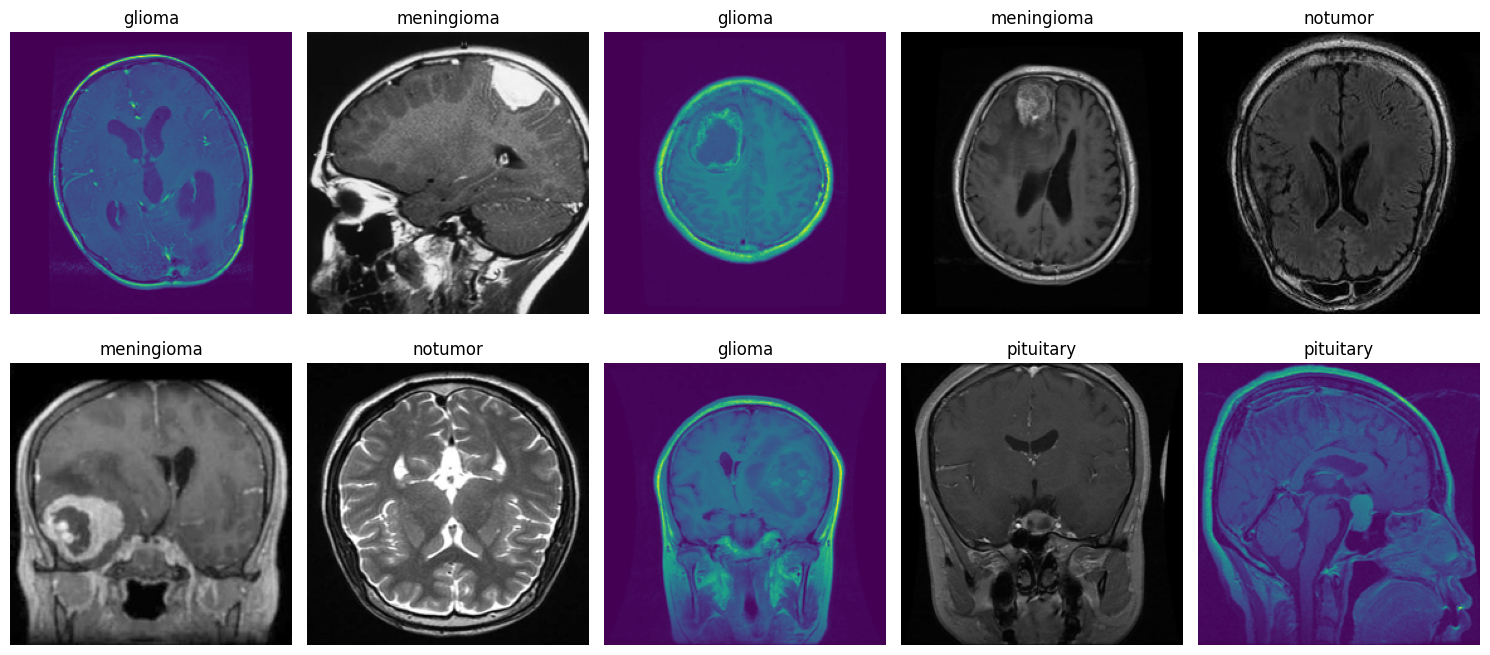

In [155]:
import matplotlib.pyplot as plt
#let's take a look at 10 random images
random_indices=random.sample(range(len(train_paths)),10)
fig,axes=plt.subplots(2,5,figsize=(15,7))
axes=axes.ravel()
for i,idx in enumerate(random_indices):
  img_path=train_paths[idx]
  img=Image.open(img_path)
  img=img.resize((224,224))
  axes[i].imshow(img)
  axes[i].set_title(train_labels[idx])
  axes[i].axis("off")
plt.tight_layout()

# **Image Preprocessing**

### Image Augmentation Function
Defined a custom `augment_image()` function to improve dataset diversity and model generalization.  
The function applies the following transformations:
- **Brightness adjustment**: Randomly varies brightness between 80%–120% of the original.  
- **Contrast enhancement**: Increases image contrast by a fixed factor of 1.5.  
- **Normalization**: Converts the image into a NumPy array and scales pixel values to the range [0, 1].  

This ensures that the model is exposed to slightly varied versions of the same MRI scans, reducing overfitting.


In [156]:
#Image Augmentation
from PIL import ImageEnhance

def augment_image(image):
  image=Image.fromarray(np.uint8(image))
  image=ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
  image=ImageEnhance.Contrast(image).enhance(1.5)
  image=np.array(image)/255.0
  return image

`open_image()`

Loads MRI images, resizes them to the target size, applies augmentation, and returns them as a NumPy array.


In [157]:
#Load images and then apply above Image Augmentation
def open_image(image_paths):
  images=[]
  for image_path in image_paths:
    img=load_img(image_path,target_size=(image_size,image_size))
    img=augment_image(img)
    images.append(img)
  return np.array(images)

`mapping function()`

Encodes class labels into integer values based on the directory structure for consistent model training.


In [158]:
def mapping_function(labels):
    unique_labels = sorted(os.listdir(train_dir))   # keep consistent order
    label2idx = {label: idx for idx, label in enumerate(unique_labels)}
    encoded = [label2idx[label] for label in labels]
    return np.array(encoded)


The `data_generator()` function is used to efficiently load data in batches during training.  
It works as follows:
- Iterates through the dataset in chunks of the specified **batch size**.  
- Loads and augments images using the `open_image()` function.  
- Encodes the corresponding labels into integer values using the `mapping_function()`.  
- Yields a tuple of `(batch_images, batch_labels)` at each step, which allows the model to process data batch by batch instead of loading the entire dataset into memory.  

This approach speeds up training and reduces memory usage, making it well-suited for large image datasets.


In [159]:
#Below function will provide data in batches so it will speed up the process
def data_generator(paths, labels, batch_size=12, epoch=1):
    for i in range(epoch):
        for j in range(0, len(paths), batch_size):
            batch_paths = paths[j:j+batch_size]
            batch_images = open_image(batch_paths)

            batch_labels = labels[j:j+batch_size]
            batch_labels = mapping_function(batch_labels)  # now gives (batch_size,)

            yield batch_images, batch_labels

# **Transfer Learning**

Transfer Learning is a technique in machine learning where a model trained on one task is reused or adapted to solve a different but related task instead of training a model from scratch

**I am using VGG16 for Transfer learning**

VGG16 is a deep convolutional neural network (CNN) architecture known for its simplicity and effectiveness in image classification tasks. It consists of 16 layers (13 convolutional layers and 3 fully connected layers) with small 3×3 convolution filters, which allows it to capture fine-grained features from images. In transfer learning, a pre-trained VGG16 model (trained on large datasets like ImageNet) is used as a feature extractor, and its learned weights are applied to a new task—in this case, brain tumor detection. By freezing the convolutional layers and training only the final classification layers on brain MRI images, VGG16 enables efficient learning with high accuracy even on relatively small datasets

# **Model Architecture**


Initialized a **VGG16** model pre-trained on ImageNet with `include_top=False` to use it as a feature extractor, and set the input shape to **128×128×3** for the MRI images.


In [160]:
#Model Architecture
image_size=128
base_model=VGG16(weights="imagenet",include_top=False,input_shape=(image_size,image_size,3))


All layers of the pre-trained **VGG16** base model were initially frozen to retain learned ImageNet features, and only the last three layers were unfrozen to fine-tune them for the brain tumor classification task.


In [161]:
#Freeze all layers of base model
for layer in base_model.layers:
  layer.trainable=False

#unfreeze last few layers which we will need
base_model.layers[-2].trainable=True
base_model.layers[-3].trainable=True
base_model.layers[-4].trainable=True

Constructed a Sequential model with the following components:  
- **Input layer** with shape `(128,128,3)` for MRI images.  
- **VGG16 base model** as a feature extractor.  
- **Flatten layer** to convert feature maps into a 1D vector.  
- **Dropout layers (0.3 and 0.2)** to reduce overfitting.  
- **Dense layer (128 units, ReLU)** for learning complex patterns.  
- **Final Dense layer (Softmax)** with neurons equal to the number of classes for multi-class classification.  


In [162]:
#Build Model
model=Sequential()
model.add(Input(shape=(image_size,image_size,3))) #input layer
model.add(base_model) #VGG16 model
model.add(Flatten()) #Flatten Layer
model.add(Dropout(0.3)) #Dropout Layer
model.add(Dense(128,activation="relu")) #Output Layer
model.add(Dropout(0.2)) #Dropout Layer
model.add(Dense(len(os.listdir(train_dir)),activation="softmax")) #Output Layer
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,908 (60.13 MB)

 Trainable params: 8,128,644 (31.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

### Model Compilation and Training
- **Compilation**: The model was compiled using the **Adam optimizer** (learning rate = 0.0001), with **sparse categorical crossentropy** as the loss function and **sparse categorical accuracy** as the evaluation metric.  
- **Training setup**: Batch size = 20, epochs = 5, and steps per epoch = `len(train_paths)/batch_size`.  
- **Training**: The model was trained using the custom `data_generator()` to feed batches of images and labels efficiently.  


In [163]:
#Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),loss="sparse_categorical_crossentropy",metrics=["sparse_categorical_accuracy"])

#Parameters
batch_size=11
steps=int(len(train_paths)/batch_size)
epochs=7

#Train model
history=model.fit(data_generator(train_paths,train_labels,batch_size=batch_size,epoch=epochs),steps_per_epoch=steps,epochs=epochs)

Epoch 1/7
119/119 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - loss: 0.9426 - sparse_categorical_accuracy: 0.6211
Epoch 2/7
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - loss: 0.3705 - sparse_categorical_accuracy: 0.8673
Epoch 3/7
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.2406 - sparse_categorical_accuracy: 0.9229
Epoch 4/7
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.1910 - sparse_categorical_accuracy: 0.9244
Epoch 5/7
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.1552 - sparse_categorical_accuracy: 0.9399
Epoch 6/7
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.1554 - sparse_categorical_accuracy: 0.9328
Epoch 7/7
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.1067 - sparse_categorical_accuracy: 0.9622


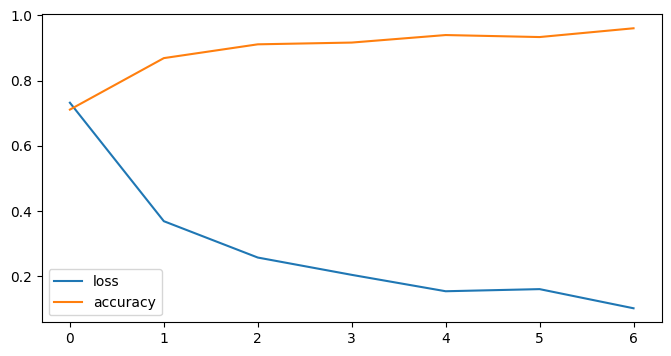

In [164]:
plt.figure(figsize=(8,4))
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["sparse_categorical_accuracy"],label="accuracy")
plt.legend()

# **Model Evaluation**

After training, the model’s performance is evaluated using the test dataset.  

Different evaluation metrics such as **accuracy, confusion matrix, classification report (precision, recall, F1-score), and loss curves** are used to understand how well the model generalizes to unseen data.


179/179 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step
Overall Accuracy: 0.9091386554621849
Overall Precision: 0.9143989528885014
Overall Recall: 0.9091386554621849
Overall F1 Score: 0.9107802969629776

Classification Report:

              precision    recall  f1-score   support

      glioma       0.90      0.91      0.91      1321
  meningioma       0.79      0.87      0.83      1339
     notumor       1.00      0.92      0.96      1595
   pituitary       0.96      0.93      0.94      1457

    accuracy                           0.91      5712
   macro avg       0.91      0.91      0.91      5712
weighted avg       0.91      0.91      0.91      5712



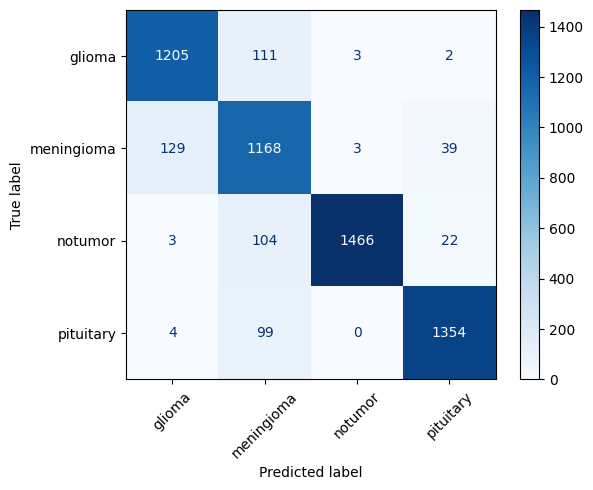

In [166]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

# Predictions
test_images = open_image(test_paths)
test_labels = mapping_function(test_labels)
test_predictions = model.predict(test_images)
test_predictions = np.argmax(test_predictions, axis=1)

# Overall Metrics
accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions, average='weighted')
recall = recall_score(test_labels, test_predictions, average='weighted')
f1 = f1_score(test_labels, test_predictions, average='weighted')

print("Overall Accuracy:", accuracy)
print("Overall Precision:", precision)
print("Overall Recall:", recall)
print("Overall F1 Score:", f1)

# Classification Report (per-class details)
print("\nClassification Report:\n")
print(classification_report(test_labels, test_predictions, target_names=sorted(os.listdir(train_dir))))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(os.listdir(train_dir)))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()
